In [1]:
#!pip install hdbscan
#conda install -c conda-forge hdbscan
#!pip install kneed

In [2]:
import pandas as pd
from IPython.display import display, HTML
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import DistanceMetric
from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise_distances


#countar os itens de uma lista
from collections import Counter
#separar treino, teste, validação
from sklearn.model_selection import train_test_split
# métricas de avaliação do K-Means
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
#
from pathlib import Path

# Definição de diretórios e Disco de leitura dos arquivos (Desktop ou Notebook) 
config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())

DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIR_BASE = DIR_PREFIXO / "Projeto_PA" / "dataset_modificado"
DIR_DBSCAN = DIRETORIO_PRINCIPAL / "DBSCAN"

In [3]:
dataset_apos_tratamento = pd.read_csv(DIR_BASE / "pacientes_completos_tratados.csv", encoding="Latin1", delimiter=";")
dataset_apos_tratamento.head()


numero_identificacao data_nascimento  genero  idade   peso altura   IMC  \
0                     4      1923-10-05       1   94.0   85.0    160  33.2   
1                     5      1948-10-07       1   70.0   80.0    165  29.4   
2                     6      1999-03-23       1   19.0  100.0    197  25.8   
3                     7      1978-01-26       0   40.0   65.0   1,64  24.2   
4                     8      1990-03-07       1   28.0  120.0    172  40.6   

            data_exame  sist 9:00  sist 9:15  ...  Mediana Diastolica em 24h  \
0  2018-09-10 12:25:23      105.0      108.0  ...                       59.0   
1  2018-12-26 07:39:41      103.0      114.0  ...                       62.0   
2  2018-12-26 08:06:19      147.0      148.0  ...                       79.0   
3  2018-12-26 08:19:06      140.0      139.0  ...                       80.0   
4  2018-12-26 08:26:59      113.0      110.0  ...                       78.0   

   AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
0                9545.5                 4902.0          3748.0   
1                8586.5                 5034.5          2915.0   
2               10674.0                 6154.0          3721.0   
3               10679.5                 6420.5          3642.0   
4                9141.5                 6118.0          2405.0   

   AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
0             841.5                16.52                 11.36   
1             606.0                 7.51                  6.65   
2             751.5                12.70                 13.01   
3             602.5                16.13                 10.34   
4             566.0                12.27                 12.79   

   Picos Sistolica  Picos Diastolica  Diferença % Dipping  
0               11                34             0.966110  
1                9                23             0.969464  
2               19                19             1.055812  
3               21                 9             1.106757  
4               10                11             1.136996  

[5 rows x 210 columns]

# Abordagem 1: MEDIDAS

In [4]:
# Dataset com as medidas
dataset_medidas = dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']

## Método para descobrir o valor ótimo do Epsilon (eps) no Dbscan

In [5]:
# Para identificar o valor ótimo de Epsilon, deve-se:
# Aplicar o método "knn", depois ordenar as distâncias e identificar onde o cotovelo aparece
# 2 pontos são considerados vizinhos se a distância entre eles é abaixo do epsilon
#
from sklearn.neighbors import NearestNeighbors
import plotly.express as px

neighbors = 7
# X_embedded is your data
nbrs = NearestNeighbors(n_neighbors=neighbors ).fit(dataset_medidas)
distances, indices = nbrs.kneighbors(dataset_medidas)
distance_desc = sorted(distances[:,-1], reverse=True)
px.line(x=list(range(1,len(distance_desc )+1)),y= distance_desc )

In [6]:
from kneed import KneeLocator
kneedle = KneeLocator(range(1,len(distance_desc)+1),  #x values
                      distance_desc, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure

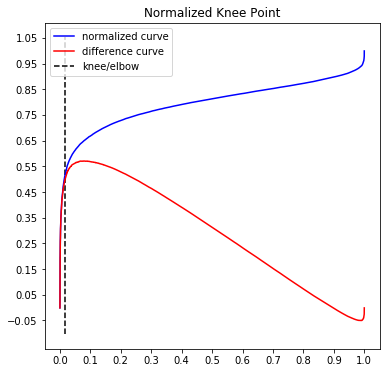

In [7]:
kneedle.plot_knee_normalized()

In [8]:
kneedle.elbow

343

In [9]:
#  Esse é o valor ótimo de eps

valor_eps_dataset_medidas=kneedle.knee_y
kneedle.knee_y

231.34606112920963

In [10]:
# Parâmetros
# epsilon: 2 pontos são considerados vizinhos se a distância entre eles é abaixo do epsilon
# min_samples: é o mínimo númerp de vizinhos um dado ponto deve ter afim de ser classificado como centroide
#   https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
#
%time dbscan_medidas = DBSCAN(eps=valor_eps_dataset_medidas, min_samples=5, metric='euclidean').fit(dataset_medidas)
#%time dbscan_medidas = DBSCAN(eps=80, min_samples=2, metric='manhattan').fit(dataset_medidas)
#%time dbscan_medidas = DBSCAN(eps=80, min_samples=2, metric='mahalanobis').fit(dataset_medidas)


Wall time: 7.39 s


In [11]:
grupo_medidas = dbscan_medidas.labels_ + 2
dataset_medidas['grupo'] = grupo_medidas
set(grupo_medidas)

{1, 2}

In [12]:
grupo_medidas

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

# Abordagem 2: Tipo de PA - Sist e Diast

In [13]:
dataset_sist = dataset_apos_tratamento.loc[:,'sist 9:00':'sist 8:45']
dataset_diast = dataset_apos_tratamento.loc[:,'diast 9:00':'diast 8:45']

In [14]:


neighbors = 6
# X_embedded is your data
nbrs = NearestNeighbors(n_neighbors=neighbors ).fit(dataset_sist)
distances, indices = nbrs.kneighbors(dataset_sist)
distance_desc = sorted(distances[:,-1], reverse=True)
px.line(x=list(range(1,len(distance_desc )+1)),y= distance_desc )

In [15]:

kneedle = KneeLocator(range(1,len(distance_desc)+1),  #x values
                      distance_desc, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure

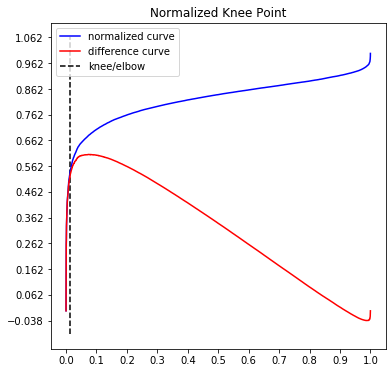

In [16]:
kneedle.plot_knee_normalized()

In [17]:
kneedle.elbow

220

In [18]:

valor_eps_dataset_sist=kneedle.knee_y
kneedle.knee_y

189.21416437465774

In [19]:
#dbscan_diast = DBSCAN(eps=10, min_samples=2, metric='mahalanobis').fit(dataset_diast)
#%time
#dbscan_sist = DBSCAN(eps=valor_eps_dataset_sist, min_samples=2, metric='mahalanobis').fit(dataset_sist)
#%time
%time dbscan_sist = DBSCAN(eps=valor_eps_dataset_sist, min_samples=2, metric='euclidean').fit(dataset_sist)

%time dbscan_diast = DBSCAN(eps=20, min_samples=2, metric='euclidean').fit(dataset_diast)


Wall time: 7.31 s
Wall time: 3.91 s


In [20]:
grupo_diast = dbscan_diast.labels_ + 2
dataset_diast['grupo'] = grupo_diast
set(grupo_diast)

{1, 2, 3, 4, 5, 6, 7, 8}

In [21]:
grupo_sist = dbscan_sist.labels_ + 2
dataset_sist['grupo'] = grupo_sist
set(grupo_sist)

{1, 2}

In [22]:
print(f'Clusters Diast:\n{set(grupo_diast)}\nnClusters:{len(set(grupo_diast))}\
        \n\nClusters Sist:\n{set(grupo_sist)}\nnClusters:{len(set(grupo_sist))}')

Clusters Diast:
{1, 2, 3, 4, 5, 6, 7, 8}
nClusters:8        

Clusters Sist:
{1, 2}
nClusters:2


# Função para gravar os outputs

In [23]:
def gera_arquivos_por_grupo(todos_dados_grupo, abordagem):
    grupos = list(set(todos_dados_grupo['grupo'].values))
    
    todos_dados_grupo.to_csv(DIR_DBSCAN / f"DBSCAN_approach_{abordagem}_todos_pacientes.csv", 
                        sep=";", encoding="latin1", index=False)
    
    for grupo in grupos:
        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
        df_grupo.to_csv(DIR_DBSCAN / f"DBSCAN_approach_{abordagem}_grupo_{grupo}.csv", 
                        sep=";", encoding="latin1", index=False)
    true_false_1_0 = {True:1, False:0}
    for doenca in list(todos_dados_grupo.loc[:,'Hipotensao':'Normotenso'].columns):
        todos_dados_grupo.loc[:,doenca] = todos_dados_grupo.loc[:,doenca].replace(true_false_1_0)
    
    todos_dados_grupo.to_csv(DIR_DBSCAN / f"DBSCAN_approach_{abordagem}_todos_pacientes.csv", 
                        sep=";", encoding="latin1", index=False)
    '''if (abordagem == 'medidas'):
        try:
            df_grupo123 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 1) | (todos_dados_grupo['grupo'] == 2) | (todos_dados_grupo['grupo'] == 3)]
            df_grupo123.to_csv(DIR_DBSCAN / f"DBSCAN_approach_{abordagem}_grupo123.csv", 
                            sep=";", encoding="latin1", index=False)

            df_grupo45 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 4) | (todos_dados_grupo['grupo'] == 5)]
            df_grupo45.to_csv(DIR_DBSCAN / f"DBSCAN_approach_{abordagem}_grupo45.csv", 
                            sep=";", encoding="latin1", index=False)

            df_grupo67 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 6) | (todos_dados_grupo['grupo'] == 7)]
            df_grupo67.to_csv(DIR_DBSCAN / f"DBSCAN_approach_{abordagem}_grupo67.csv", 
                            sep=";", encoding="latin1", index=False)
        except:
            pass'''

In [24]:
dados_completos_medidas = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    dataset_medidas['grupo'],
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_medidas= dados_completos_medidas.replace(genero_M_F)



In [25]:
dados_completos_sist = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    dataset_sist['grupo'],
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_sist= dados_completos_sist.replace(genero_M_F)


In [26]:
dados_completos_diast = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    dataset_diast['grupo'],
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_diast= dados_completos_diast.replace(genero_M_F)


##  Grava arquivo da abordagem 1 - Medidas

In [27]:
gera_arquivos_por_grupo(dados_completos_medidas,'medidas')

##  Grava arquivo da abordagem 2 - TIPOS DE PA

In [28]:
gera_arquivos_por_grupo(dados_completos_sist,'sist')

In [29]:
gera_arquivos_por_grupo(dados_completos_diast,'diast')

In [30]:
dir(dbscan_medidas)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'algorithm',
 'components_',
 'core_sample_indices_',
 'eps',
 'fit',
 'fit_predict',
 'get_params',
 'labels_',
 'leaf_size',
 'metric',
 'metric_params',
 'min_samples',
 'n_features_in_',
 'n_jobs',
 'p',
 'set_params']